# Lending Club -- Which loans will be paid back?

[Lending Club](https://www.lendingclub.com) is a company that operates in the USA and facilitates peer to peer loans. The lenders can invest their money to fund the loans and in return they earn profit from the interests paid by the borrowers. The investers can choose to invest in one of the five categories; **A, B, C, D,** and **E**. The investment strategy **A** yields the minimum returns but also involves a minimum risk while the investment strategy **E** yields maximum returns but involves the highest risk that loan will not be paid back.

The Lending Club have provided its [data](https://www.lendingclub.com/info/download-data.action) for researches to use for study purpose.

## Data

The data used in this study is composed of four files available on the website of the Lending Club; _LoanStats3a.csv, LoanStats3b.csv, LoanStats3c.csv_ and _LoanStats3d.csv_ which contain data for the loans facilitated by the company in 2007-2011, 2012-2013, 2014, and 2015 respectively.

## Python libraries used for the study
The following python libraries are being used in theis study:
1. `pandas`
1. `sklearn`
1. `matplotlib`
1. `numpy`
1. `seaborn`
1. `eli5`

## Load required modules
The following modules will be required in this project.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline

## Load and view data
After downloading the datasets, the extra rows on the top and bottom of the csv files are removed that would make it hard for pandas to read the files cleanly.

In [2]:
loans_a = pd.read_csv("raw_data/LoanStats3a.csv", low_memory = False)
loans_b = pd.read_csv("raw_data/LoanStats3b.csv", low_memory = False)
loans_c = pd.read_csv("raw_data/LoanStats3c.csv", low_memory = False)
loans_d = pd.read_csv("raw_data/LoanStats3d.csv", low_memory = False)
    
loans = loans_a.append(loans_b, ignore_index = True)
loans = loans.append(loans_c, ignore_index = True)
loans = loans.append(loans_d, ignore_index = True)
    
del loans_a
del loans_b
del loans_c
del loans_d

In [3]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

display_all(loans.tail().transpose())

,887435,887436,887437,887438,887439
loan_amnt,10000,24000,13000,12000,20000
funded_amnt,10000,24000,13000,12000,20000
funded_amnt_inv,10000,24000,13000,12000,20000
term,36 months,36 months,60 months,60 months,36 months
int_rate,11.99%,11.99%,15.99%,19.99%,11.99%
installment,332.1,797.03,316.07,317.86,664.2
grade,B,B,D,E,B
sub_grade,B5,B5,D2,E3,B5
emp_title,Office Assistant,Director of Maintenance,Radiologist Technologist,Painter,Manager Hotel Operations Oasis
emp_length,8 years,10+ years,5 years,1 year,10+ years


## Data cleaning

### Remove unwanted variables

There are 141 variables in this data set. The variables $grade$ and $sub\_grade$ are credit risk bands assigned by the Lending Club to each loan. We will remove these columns and will try to model the loan status without these variables. Also, the variables $pymnt\_plan$ and $emp\_title$ are highly verbose and hard to quantify, we will remove those also. Although these may be useful for natural language processing or words analysis.

In [4]:
loans.drop(['grade', 'sub_grade', 'pymnt_plan', 'emp_title'], axis=1, inplace=True)

### Date columns

The dates cannot be used directly in the modelling. We will therefore extract year and month from the date variables and fill the missing dates with zero month and zero year.

In [5]:
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d', 'debt_settlement_flag_date'
            , 'settlement_date']
for col in date_cols:
    loans[[col+'_month', col+'_year']] = loans[col].str.split('-', expand = True)
    loans[col+'_month'] = loans[col+'_month'].map({'Jan': 1, 'Feb': 2, 'Mar' : 3, 'Apr' : 4, 'May' : 5, 'Jun' : 6
                                                  , 'Jul' : 7, 'Aug' : 8, 'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12})
    loans[[col+'_month', col+'_year']] = loans[[col+'_month', col+'_year']].fillna(value=0)
    loans[[col+'_month', col+'_year']] = loans[[col+'_month', col+'_year']].astype(int)
loans.drop(date_cols, axis=1, inplace=True)

### Format the rate columns

The rate columns need to be formatted as python float variables

In [6]:
rate_cols = ['int_rate', 'revol_util']
for col in rate_cols:
    loans[col] = pd.to_numeric(loans[col].str.replace('%',''))

### Clean the target variable -- $loan\_status$
There are multiple values of the variable $loan\_status$


|Variable|Frequency|Percentage|
|--------|---------|------|
|Fully Paid|637715|71.9%|
|Charged Off|147424|16.6%|
|Current|92970|10.5%|
|Late (31-120 days)|3545|0.4%|
|Does not meet the credit policy. Status:Fully Paid|1988|0.2%|
|In Grace Period|1896|0.2%|
|Late (16-30 days)|965|0.1%|
|Does not meet the credit policy. Status:Charged Off|761|0.1%|
|Default|176|0.0%|

We would like to remove the $loan\_status = Current$ records as these loans are still not fully paid back and we dont know their final outcome. For our purpose we will only consider the records where $loan\_status$ has the following values
1. **`Fully Paid`** and count it as **`good`**
1. **`Charged Off`** and count it as **`bad`**
1. **`Does not meet the credit policy. Status:Fully Paid`** and count it as **`good`**
1. **`Does not meet the credit policy. Status:Charged Off`** and count it as **`bad`**

We will remove the records with the following outcomes in addition to **`Current`**
1. **`Late (31-120 days)`**
1. **`In Grace Period`**
1. **`Late (10-30 days)`** and
1. **`Default`**

In [7]:
loans['loan_status'] = loans['loan_status'].map({'Fully Paid': 'good'
         , 'Does not meet the credit policy. Status:Fully Paid': 'good'
         , 'Charged Off' : 'bad'
         , 'Does not meet the credit policy. Status:Charged Off' : 'bad'})
    
loans = loans[loans['loan_status'].isin(['good', 'bad'])]

### Missing values
It is important to investigate the variables containing the missing values.

In [8]:
allMissing = loans.isnull().sum().sort_values(ascending=False)
percentage = (loans.isnull().sum()/loans.isnull().count()).sort_values(ascending=False)
missingData = pd.concat([allMissing, percentage*100], axis=1, keys=['TotalMissing', 'Percentage'])
missingData.head(50)

,TotalMissing,Percentage
sec_app_open_act_il,787888,100.000000
revol_bal_joint,787888,100.000000
sec_app_chargeoff_within_12_mths,787888,100.000000
sec_app_num_rev_accts,787888,100.000000
sec_app_collections_12_mths_ex_med,787888,100.000000
sec_app_revol_util,787888,100.000000
sec_app_open_acc,787888,100.000000
sec_app_mort_acc,787888,100.000000
sec_app_inq_last_6mths,787888,100.000000
sec_app_earliest_cr_line,787888,100.000000


We will drop the variables containing 99% or more missing values.

In [9]:
drop_missing = missingData[:29].index
loans.drop(labels = drop_missing, axis = 1, inplace = True)

In [10]:
minus_1_cols = list(missingData[missingData['TotalMissing'] > 0].index)
minus_1_cols = [col for col in minus_1_cols if
                col not in ['title', 'settlement_status', 'annual_inc', 'dti'] + list(missingData[:29].index)]

for col in minus_1_cols:
    loans[col] = loans[col].fillna(value = -1)

loans.title = loans.title.fillna(value = 'na')
loans.settlement_status = loans.settlement_status.fillna(value = 'na')

loans.annual_inc = loans.annual_inc.fillna(value = loans.annual_inc.mean())
loans.dti = loans.dti.fillna(value = loans.dti.mean())

The variable $pub\_rec\_bankruptcies$ is a number of public record bankruptcies as explained in the data dictionary on the data page of lending club. This variable has a zero value for most of the cases while some loans have this value more than zero. The maximum of this value found in this data set is 12. I am tempted to drop this variable. The reason I am dropping this is that I do not want to remove 1365 observations and also do not want to replace the missing values with my assumptions.

The variable $last\_pymnt\_d$ is missing whenever the debt is bad. I am again dropping this variable.

The variables $revol\_util$, $collections\_12\_mths\_ex\_med$, $chargeoff\_within\_12\_mths$, $tax\_liens$, $title$, $last\_credit\_pull\_d$ should also be dropped. Also the variables $delinq\_amnt$, $acc\_now\_delinq$, $delinq\_2yrs$, $earliest\_cr\_line$, $inq\_last\_6mths$, $open\_acc$, $pub\_rec$, and $total\_acc$ are missing whenever the value of $verification\_status$ is 'Not Verified'. We are going to drop these variables too.

Finally the observationas where the variables $annual\_inc$ and $dti$ are missing can be dropped.

In [11]:
str_cols = loans.select_dtypes(include=[object]).columns.tolist()
str_cols = [col for col in str_cols if col != 'loan_status']
for col in str_cols:
    loans[col] = loans[col].astype("category").cat.codes

In [12]:
loans.std().sort_values().head(10)

out_prncp_inv                 0.000000
policy_code                   0.000000
hardship_flag                 0.000000
out_prncp                     0.000000
disbursement_method           0.000000
application_type              0.019896
acc_now_delinq                0.076988
chargeoff_within_12_mths      0.107208
collections_12_mths_ex_med    0.132769
debt_settlement_flag          0.141382
dtype: float64

In [13]:
loans.drop(['out_prncp_inv', 'policy_code', 'hardship_flag', 'out_prncp', 'disbursement_method'], axis=1, inplace=True)

## Collinear numerical variables

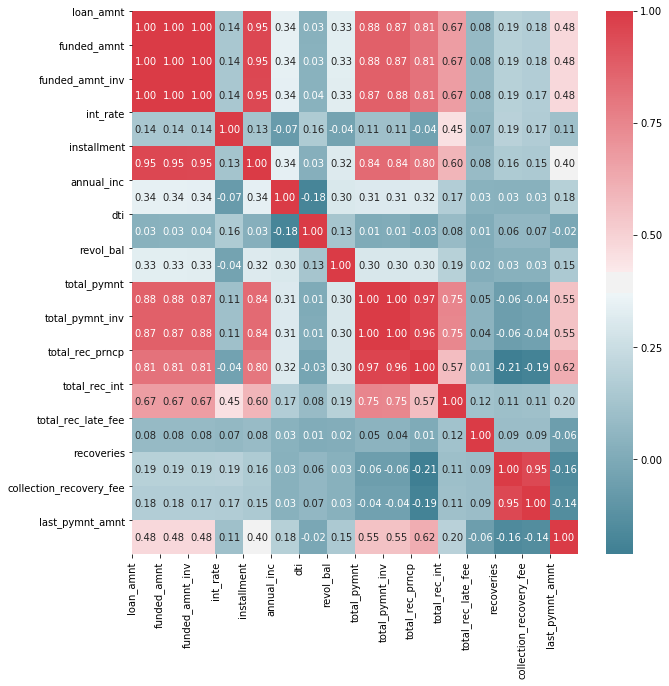

In [14]:
num_cols = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_bal'
    , 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries'
    , 'collection_recovery_fee', 'last_pymnt_amnt'
]
corrmat = loans[num_cols].corr()
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corrmat, cmap=colormap, annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corrmat.columns)), corrmat.columns);
#Apply yticks
plt.yticks(range(len(corrmat.columns)), corrmat.columns)
#show plot
plt.show()

The variable $dti$ should be capped at 100% as debt-to-income ratio in a month cannot be more than 100%. Also consider the fact that all six of the loans that have more than 100% $dti$ are fully paid or `good`. Also, we notice that for some reason we have six observations where the variable $out\_prncp$ is 100. This cannot be true; a more detailed investiigation shows that these observations are erroneous and can be dropped.

A further investigation shows that the variables $out\_prncp$, $out\_prncp\_inv$, and $policy\_code$ have zero standard deviation and can simply be dropped.

In [15]:
cols_to_drop = [
    'funded_amnt', 'funded_amnt_inv', 'installment', 'total_pymnt_inv', 'total_rec_prncp', 'collection_recovery_fee'
]
loans.drop(labels = cols_to_drop, axis = 1, inplace = True)

## Feature Selection
Let us fit a simple Logistic Regression model with the default parameters using all the explanatory variables we decided to keep so far. We will apply 5 Folds cross validation to get a better understanding of how the model performs on average on all five of the test sets of the cross validation.

We have decided to choose **F1 Score** as the performance metric in this case. F1 score is a harmonic mean of the **precision** and **recall** metrics. These are defined as:
### Precision
Precision is the number of True Positives divided by the number of True Positives and False Positives of confusion matrix. In simple words, it is the number of positive predictions divided by the total number of positive class values predicted.
$$precision = \frac{TP}{TP + FP}$$
### Recall
Recall is the number of True Positives divided by the number of True Positives and the number of False Negatives. In other words, it is the number of positive predictions divided by the number of positive class values in the test data.
$$recall = \frac{TP}{TP + FN}$$
### F1 Score
$$\frac{1}{F1\_score} = \frac{1}{2}\left(\frac{1}{precision} + \frac{1}{recall}\right)$$
or
$$F1\_score = \frac{2 \times precision \times recall}{precision + recall}$$

Since, our problem does not have balanced outcomes, the _accuracy_ is not a very good performance metric, e.g., if there are 5% bad loans, a model that predicts all good loans will still have a 95% accuracy but we know that this will be a very bad model.

We have taken $loan\_status = bad$ as the positive outcome in this case.

From the distribution plots, it seems like the variable $annual\_inc$ is not very helpful in explaining the response variable. Moreover, the variables:
1. $revol\_bal$ and $total\_rec\_late\_fee$
1. $total\_pymnt$ and $total\_pymnt\_inv$
1. $recoveries$ and $collection\_recovery\_fee$
1. $funded\_amnt$, $loan\_amnt$ and $funded\_amnt\_inv$

my_scorer = make_scorer(my_loss_func, greater_is_better = False)are strongly correlated. We will drop the variables $annual\_inc$, $revol\_bal$, $total\_pymnt\_inv$, $collection\_recovery\_fee$, $loan\_amnt$, and $funded\_amnt\_inv$. The average performance score will then be compared to see if the results worsen.

In [16]:
def my_loss_func(xx, yy):
    return f1_score(xx, yy, pos_label = 'bad', average = 'binary')

my_scorer = make_scorer(my_loss_func, greater_is_better = True)

folds = StratifiedKFold(n_splits = 5)
rf_cl = RandomForestClassifier(n_jobs = -1)

scores = cross_val_score(rf_cl
                         , loans.loc[:, loans.columns != 'loan_status']
                         , loans['loan_status']
                         , cv=folds
                         , scoring=my_scorer)
print('The 95% confidence interval of the f1 score with all the variables is {:.3f} \u00B1 {:.3f}.'
      .format(np.mean(scores), 2*np.std(scores)))

The 95% confidence interval of the f1 score with all the variables is 0.947 ± 0.051.


In [17]:
def eli5_scorer(estimator, X, y):
    yhat = estimator.predict(X)
    return(f1_score(yhat, y, pos_label = 'bad', average = 'binary'))

X_train, X_test, y_train, y_test = train_test_split(loans.loc[:, loans.columns != 'loan_status']
                                                    , loans['loan_status']
                                                    , test_size=0.25
                                                    , random_state=42
                                                   , stratify = loans['loan_status'])
rf_cl2 = RandomForestClassifier(n_jobs = -1)
rf_cl2.fit(X_train, y_train)
perm = PermutationImportance(rf_cl2, scoring = eli5_scorer)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top = 50)

Weight,Feature
0.3228 ± 0.0018,recoveries
0.2098 ± 0.0020,total_pymnt
0.1161 ± 0.0013,loan_amnt
0.0701 ± 0.0013,last_pymnt_amnt
0.0267 ± 0.0012,term
0.0182 ± 0.0004,total_rec_int
0.0119 ± 0.0009,issue_d_year
0.0101 ± 0.0004,last_pymnt_d_year
0.0024 ± 0.0006,last_credit_pull_d_month
0.0022 ± 0.0004,last_credit_pull_d_year


In [18]:
top_features = ['recoveries', 'total_pymnt', 'loan_amnt', 'last_pymnt_amnt', 'term', 'total_rec_int', 'issue_d_year'
                , 'last_pymnt_d_year', 'last_credit_pull_d_year', 'last_credit_pull_d_month', 'int_rate'
                , 'annual_inc', 'last_pymnt_d_month', 'total_rec_late_fee', 'num_op_rev_tl', 'initial_list_status'
                , 'issue_d_month', 'settlement_date_year', 'tot_hi_cred_lim', 'total_rev_hi_lim', 'verification_status'
                , 'avg_cur_bal', 'num_actv_rev_tl', 'revol_bal', 'num_tl_90g_dpd_24m', 'total_bal_ex_mort'
                , 'acc_open_past_24mths', 'settlement_date_month', 'settlement_term', 'title', 'num_actv_bc_tl'
                , 'num_sats', 'num_rev_tl_bal_gt_0', 'mths_since_last_major_derog', 'tot_cur_bal', 'addr_state'
                , 'mo_sin_old_rev_tl_op', 'zip_code', 'bc_open_to_buy', 'mths_since_recent_bc_dlq', 'purpose'
                , 'num_bc_tl', 'tot_coll_amt', 'total_il_high_credit_limit', 'mths_since_last_record', 'pub_rec_bankruptcies']
loans = loans[top_features + ['loan_status']]

In [19]:
rf_cl3 = RandomForestClassifier(n_jobs = -1)

scores = cross_val_score(rf_cl3
                         , loans.loc[:, loans.columns != 'loan_status']
                         , loans['loan_status']
                         , cv=folds
                         , scoring=my_scorer)
print('The 95% confidence interval of the f1 score with all the variables is {:.3f} \u00B1 {:.3f}.'
      .format(np.mean(scores), 2*np.std(scores)))

The 95% confidence interval of the f1 score with all the variables is 0.940 ± 0.058.
